In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile

# Specify the path to the tarball file
tarball_path = "/content/drive/MyDrive/Colab Notebooks/UTKFace (1).tar.gz"

# Extract the contents of the tarball
with tarfile.open(tarball_path, 'r:gz') as tar_ref:
    tar_ref.extractall("/content")

In [ ]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        #img = cv2.GaussianBlur(img, (3, 3), 0)  # Appliquer un filtre de Gauss pour le lissage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import cv2

# Charger InceptionV3 pré-entraîné sans les couches fully connected
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = True

# Créer un modèle séquentiel
model = models.Sequential()

# Ajouter InceptionV3 comme couche de base
model.add(base_model)

# Ajouter des couches supplémentaires pour la détection de l'âge
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear', name='age'))

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Afficher le résumé du modèle
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 age (Dense)                 (None, 1)                 513       
                                                                 
Total params: 22852385 (87.17 MB)
Trainable params: 22817953 (87.04 MB)
Non-trainable params: 34432 (134.50 KB)
__________

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70, shuffle = True)

Epoch 1/70
72/72 [==============================] - 71s 385ms/step - loss: 343.3356 - mae: 13.4869 - val_loss: 1271.9211 - val_mae: 29.6030
Epoch 2/70
72/72 [==============================] - 18s 248ms/step - loss: 201.8117 - mae: 10.8791 - val_loss: 428.9686 - val_mae: 16.1647
Epoch 3/70
72/72 [==============================] - 19s 257ms/step - loss: 136.3108 - mae: 8.8971 - val_loss: 217.2410 - val_mae: 11.0478
Epoch 4/70
72/72 [==============================] - 18s 251ms/step - loss: 120.8746 - mae: 8.3597 - val_loss: 195.1248 - val_mae: 9.5601
Epoch 5/70
72/72 [==============================] - 18s 245ms/step - loss: 118.0420 - mae: 8.3329 - val_loss: 179.2573 - val_mae: 9.7186
Epoch 6/70
72/72 [==============================] - 18s 245ms/step - loss: 88.4013 - mae: 7.1936 - val_loss: 145.0286 - val_mae: 9.0629
Epoch 7/70
72/72 [==============================] - 18s 250ms/step - loss: 70.7294 - mae: 6.4619 - val_loss: 149.8015 - val_mae: 8.6241
Epoch 8/70
72/72 [===================

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 1s 66ms/step - loss: 86.4232 - mae: 6.6332
Test Loss: 86.42317962646484, Test MAE: 6.6332197189331055


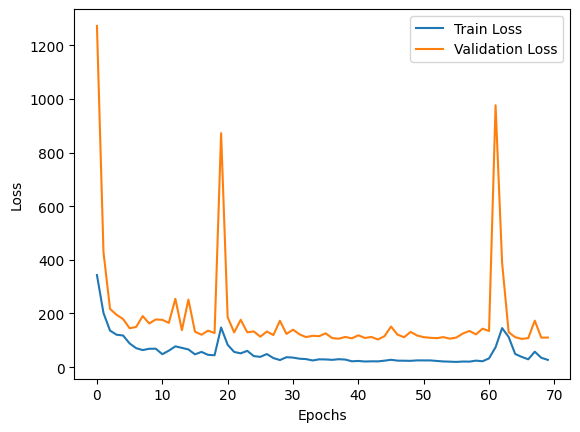

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 2s 69ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 34.          25.822155  ]
 [ 52.          50.64526367]
 [ 58.          57.02012634]
 [ 27.          24.83224869]
 [ 40.          45.56434631]
 [ 13.           6.34078646]
 [ 64.          59.99066544]
 [ 72.          71.61694336]
 [ 31.          27.19112968]
 [ 84.          92.46396637]
 [ 60.          62.69880295]
 [ 52.          33.65551758]
 [  6.           5.21680927]
 [ 54.          48.78073883]
 [ 33.          38.49973679]
 [ 93.          81.90665436]
 [ 48.          61.72910309]
 [ 15.          20.25441933]
 [  7.           5.16622591]
 [ 25.          25.19902039]
 [  4.           8.16920471]
 [ 32.          19.96526718]
 [ 12.          32.45549011]
 [ 52.          49.51428604]
 [ 59.          67.53513336]
 [ 53.          60.7582016 ]
 [ 21.           5.08259535]
 [ 44.          22.31031609]
 [ 74.          65.78140259]
 [ 92.          81.64691162]
 [ 19.          16.25771904]
 [ 60.      

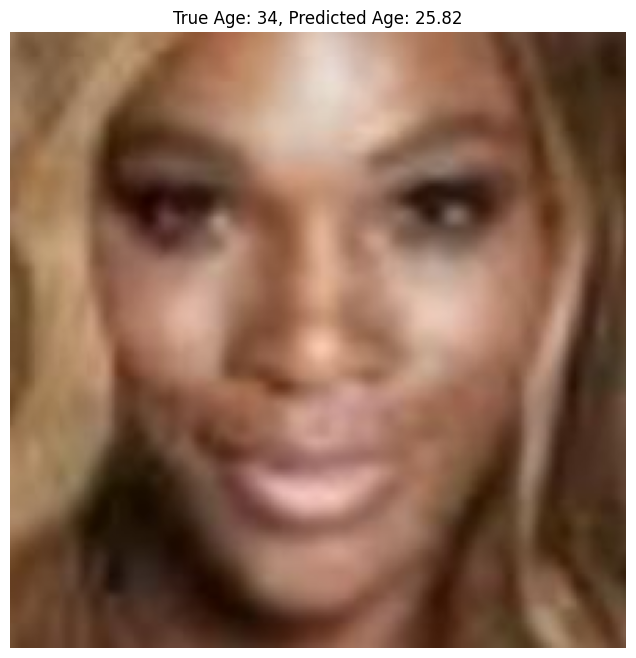

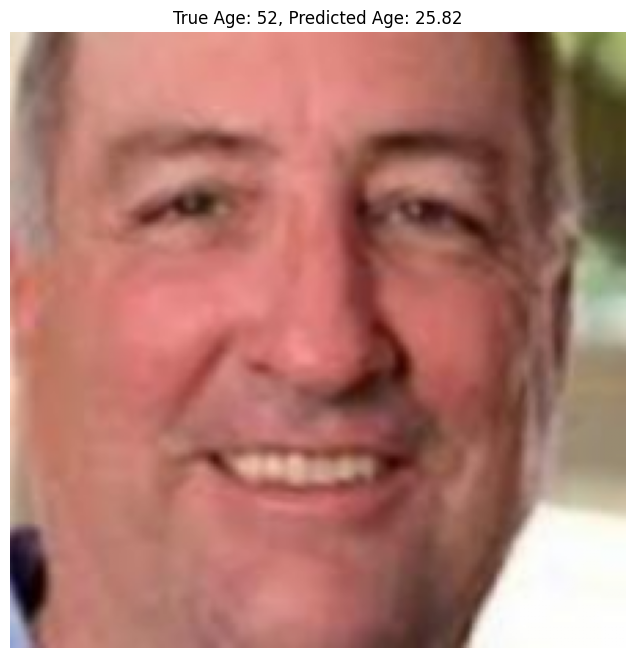

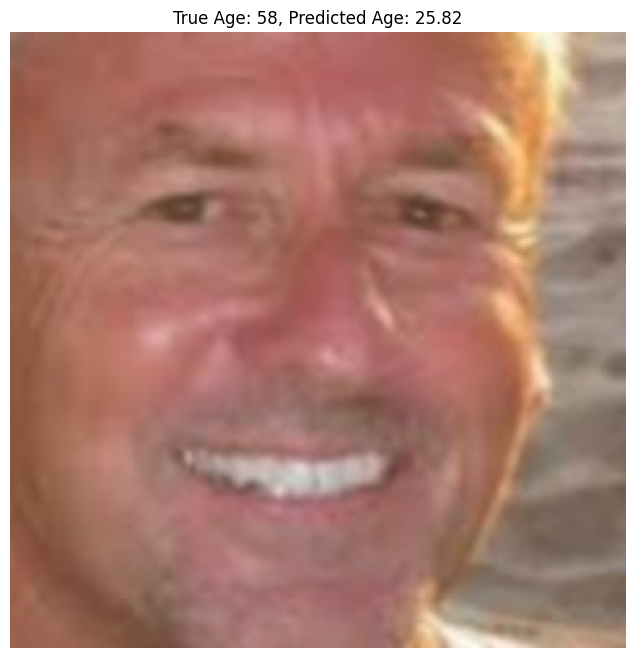

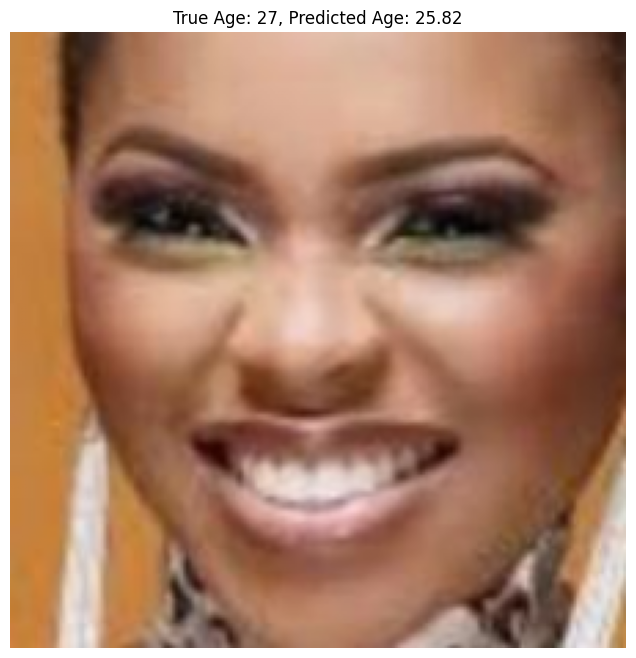

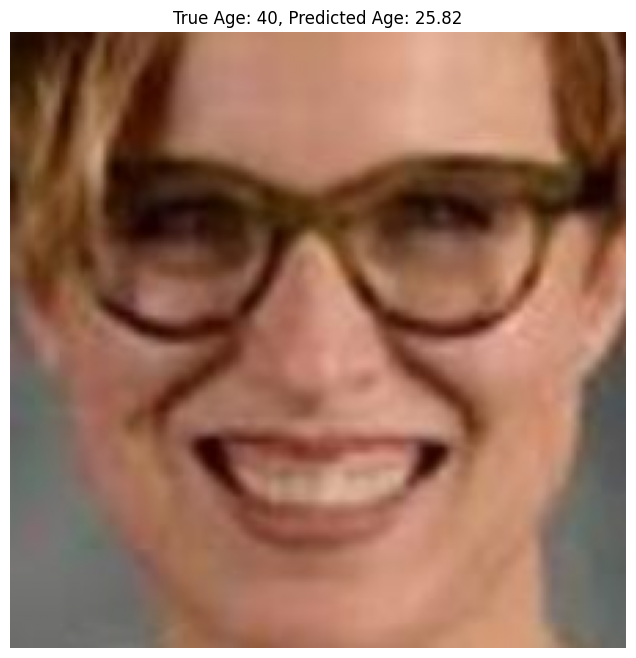

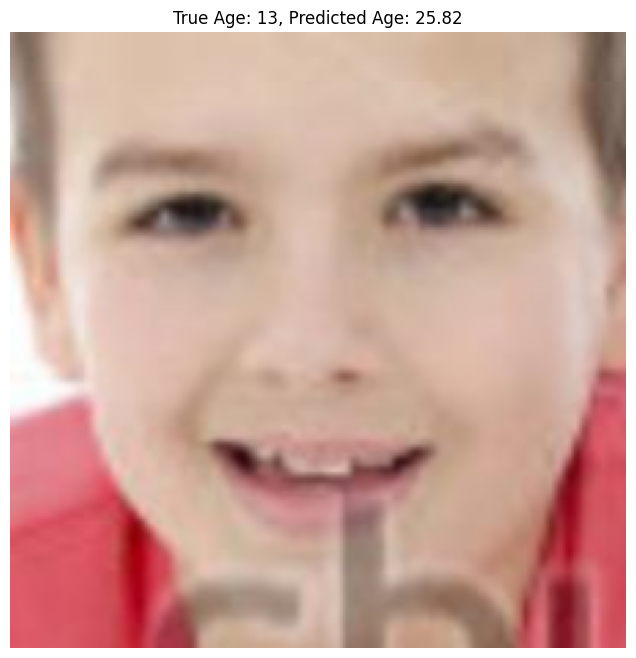

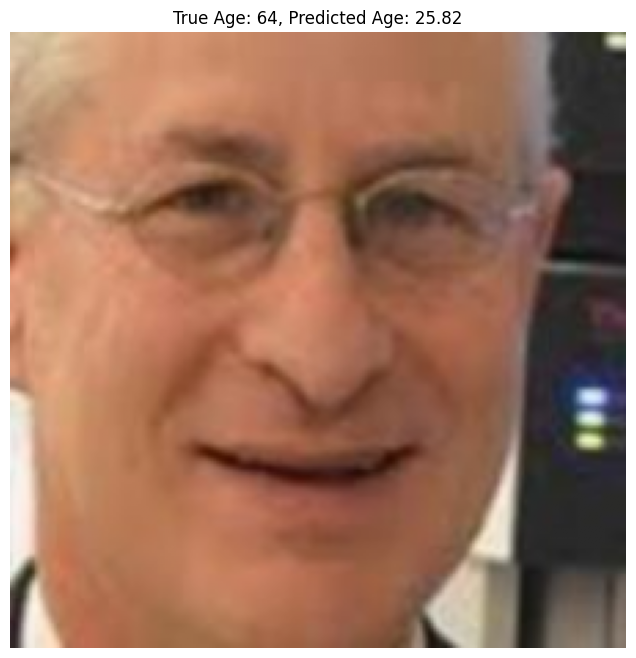

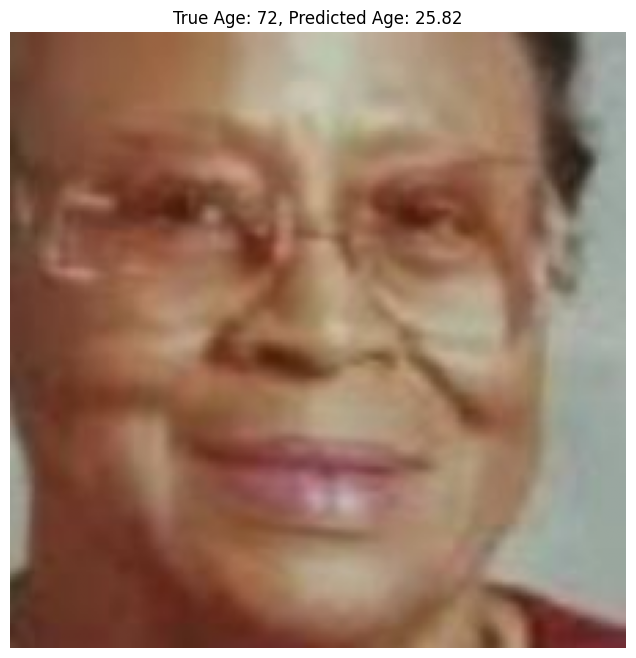

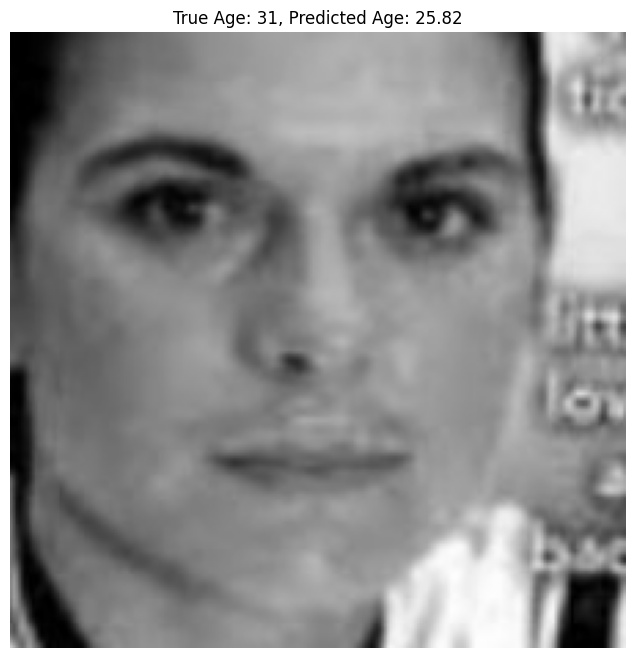

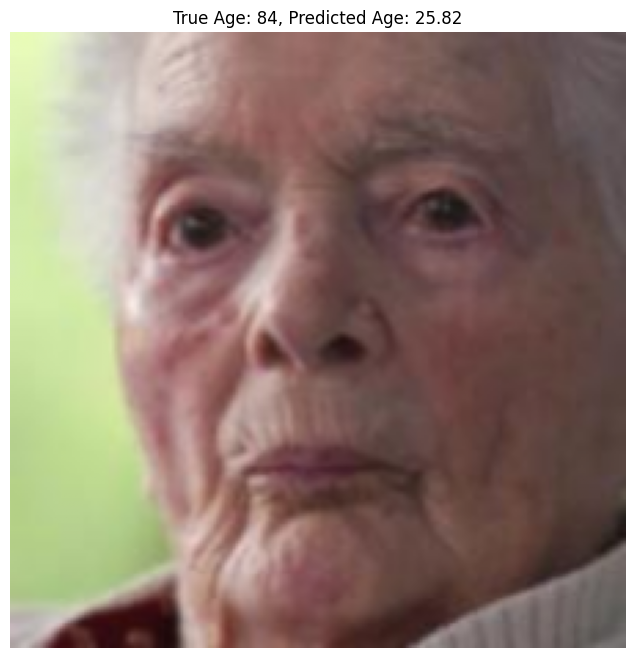

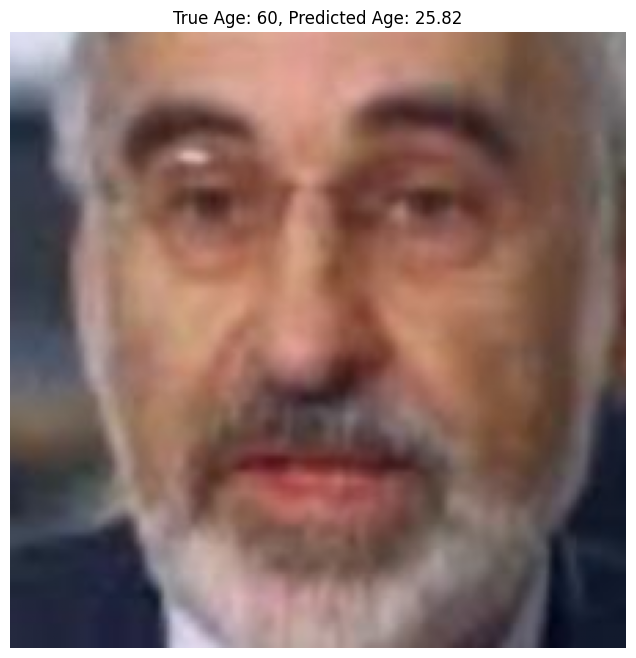

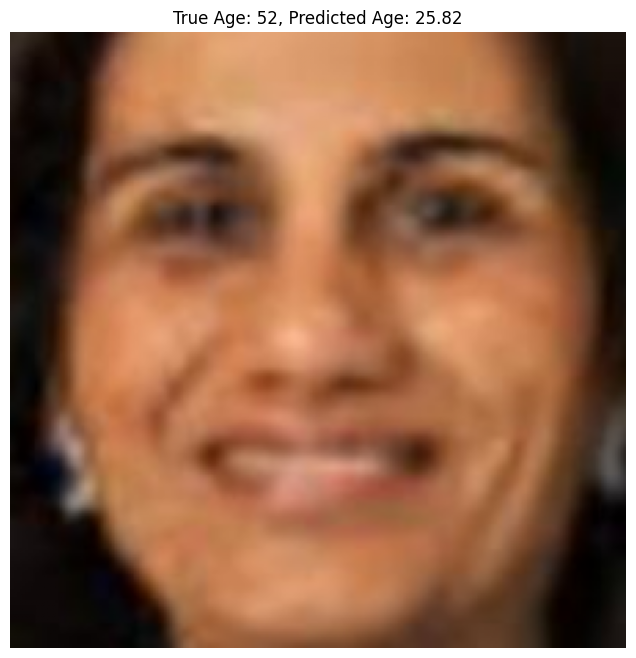

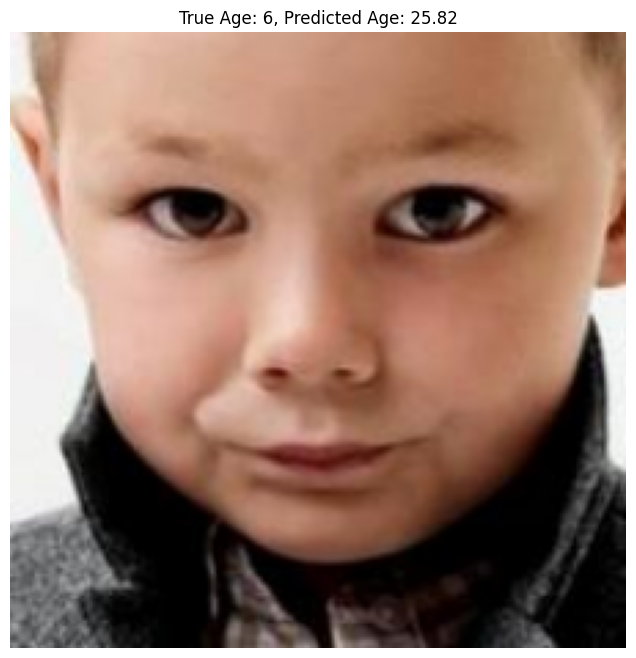

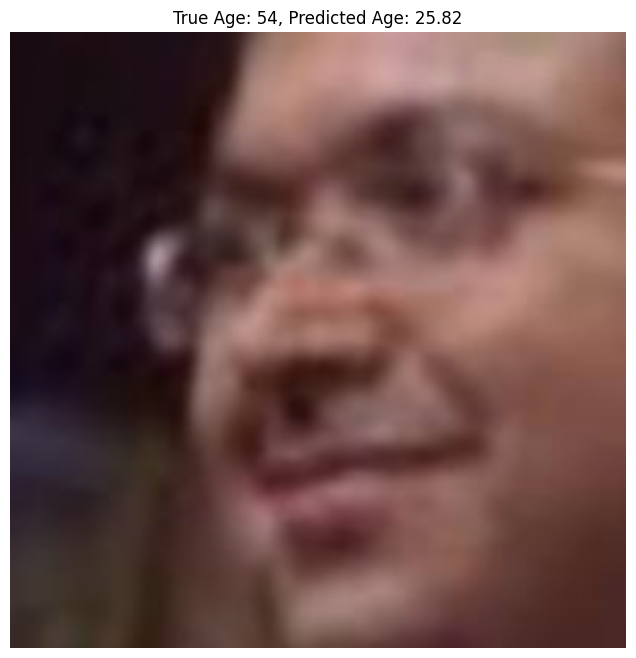

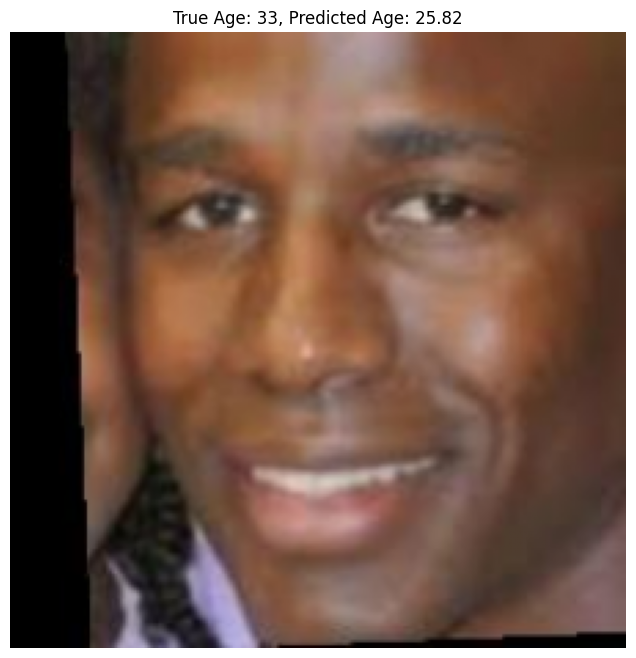

In [ ]:
# Afficher les images avec les prédictions d'âge comme titre
num_images_to_display = 15  # Vous pouvez ajuster le nombre d'images à afficher

for i in range(num_images_to_display):
    plt.figure(figsize=(8, 8))
    plt.imshow(X_test[i])
    true_age = y_test[i]
    predicted_age = predictions[0,0]
    plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 6.63
MSE: 86.42
RMSE: 9.30
R^2: 0.88


In [ ]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.66%
